#### Import libraries and read files

In [48]:
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import nltk
import joblib as jb
# from sklearn.externals import joblib
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
import pandas as pd 
import numpy as np


[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
df = pd.read_csv("data/emotion_data_updated.csv")
df.head()

,Emotion,Url,color,rgb,palette
0,shocked,https://www.pngfind.com/pngs/m/104-1041539_sho...,"(237, 224, 216)","[(237, 224, 216), (66, 28, 17), (146, 85, 55),...","['antiquewhite', 'maroon', 'sienna', 'peru']"
1,shocked,https://cdn1.vectorstock.com/i/1000x1000/09/00...,"(241, 170, 34)","[(47, 13, 26), (241, 170, 34), (232, 236, 233)...","['black', 'goldenrod', 'lavender', 'firebrick']"
2,shocked,https://img.freepik.com/free-photo/shocked-fac...,"(202, 200, 200)","[(201, 200, 200), (54, 45, 42), (166, 119, 95)...","['silver', 'darkslategray', 'indianred', 'sien..."
3,shocked,http://www.clker.com/cliparts/f/8/8/e/13918408...,"(213, 208, 204)","[(201, 195, 190), (63, 54, 48), (101, 90, 82),...","['silver', 'darkslategray', 'dimgray', 'dimgray']"
4,shocked,https://pics.me.me/let-me-show-you-my-shocked-...,"(68, 68, 68)","[(84, 85, 84), (208, 210, 212), (190, 161, 145...","['dimgray', 'lightgray', 'rosybrown', 'darkgray']"


In [40]:
# Replace two labels so Wordnet can read the emotions
df['Emotion'] = df['Emotion'].replace('open-hearted', 'openhearted')
df['Emotion'] = df['Emotion'].replace('clear-headed', 'clearheaded')

In [86]:
import ast

In [91]:
df['color'] = df['color'].apply(ast.literal_eval)
# test2 = df['color'].astype(np.float16)

In [92]:
# Define a semantic loss function 
def semantic_loss(truth, pred):
  error = 0 
  for i in range(0, len(pred)):
    truth_i = wn.synsets(truth[i])[0]
    pred_i = wn.synsets(truth[i])[0]
    error_i = truth_i.path_similarity(pred_i)
    error += error_i
  return error

In [93]:
# Grab our data
X = df['color'].tolist()
y = df['Emotion'].tolist()

In [94]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) 

In [95]:
# Make scoring function
scorer = make_scorer(semantic_loss, greater_is_better=False)

In [96]:
# Center and scale (i.e., standardize) all numeric features
# Z-score
scaler = StandardScaler()




In [97]:
np.array(X_train,dtype=float)

array([[140., 134., 129.],
       [188., 109.,  75.],
       [ 94.,  89., 110.],
       ...,
       [116., 116., 116.],
       [  4.,   4.,   4.],
       [ 35.,  32.,  10.]])

In [98]:
X_train = scaler.fit_transform(X_train)

In [99]:

X_test = scaler.transform(X_test)

In [100]:
# create KNN model object
knn = KNeighborsClassifier(n_neighbors=5)

# Train Knn Classifer
knn = knn.fit(X_train,y_train)

In [101]:
# create KNN model object
knn = KNeighborsClassifier()



In [102]:
# Create grid of hyperparameter values
hyper_grid = {'n_neighbors': range(1, 100, 5)}

In [104]:
# Tune a knn model using grid search
grid_search = GridSearchCV(knn, hyper_grid, cv=5, scoring=scorer)


In [105]:
results = grid_search.fit(X_train, y_train)



/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [106]:
# Best model's cross validated RMSE
abs(results.best_score_)

779.8

In [107]:
# Best model's k value
optimal_k = results.best_estimator_.get_params().get('n_neighbors')
optimal_k

1

In [116]:
from ggplot import *

AttributeError: module 'pandas' has no attribute 'tslib'

In [114]:
import rpy2

In [108]:
# Plot all RMSE results
all_errors = pd.DataFrame({
  'k': range(1, 100, 5),
  'accuracy': results.cv_results_['mean_test_score']
  })

(ggplot(all_errors, aes(x='k', y='accuracy'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))

NameError: name 'ggplot' is not defined

In [117]:
knn_best = KNeighborsClassifier(n_neighbors=optimal_k)
knn_best_fit = knn_best.fit(X_train, y_train)

In [119]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [120]:
predictions = knn_best_fit.predict(X_train)
cm = confusion_matrix(y_train, predictions)
cm

array([[26,  0,  0, ...,  0,  0,  0],
       [ 0, 24,  0, ...,  0,  0,  0],
       [ 0,  0, 22, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  7,  0,  0],
       [ 0,  0,  0, ...,  0, 17,  0],
       [ 0,  0,  0, ...,  0,  0, 27]])

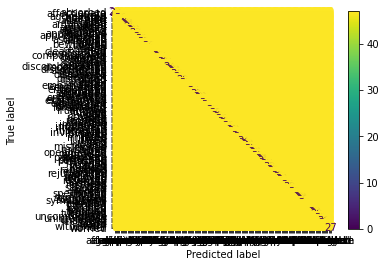

In [122]:
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=knn_best_fit.classes_
  )
  
disp.plot()

In [123]:
#Confusion Matrix of the X_test y_test

predictions =  knn_best_fit.predict(X_test)
cm1 = confusion_matrix(y_test, predictions)
cm1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [124]:
#Confusion Matrix of the X_test y_test Visualized
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm1,
  )
  
disp.plot()

In [ ]:
#Predict the response for test dataset
knn = knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
print(metrics.classification_report(y_test, knn.predict(X_test)))